Using librosa for audio preprocessing

In [ ]:
!pip install librosa

Mounting drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Importing Libraries

In [ ]:
import librosa
import os
import pandas as pd
import numpy as np
import torch
import torch.nn.functional as F
from torch.nn.utils.rnn import pad_sequence
import torch.nn as nn
import torch.optim as optim
import cv2

Accesing GPU

In [ ]:
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

Loading Data

In [ ]:
csv_file_path='/content/drive/MyDrive/archive (24)/TRAIN.csv'
folder_path_train='/content/drive/MyDrive/archive (24)/TRAIN'


In [ ]:
df=pd.read_csv('/content/drive/MyDrive/archive (24)/TRAIN.csv')

In [ ]:
df

,Filename,Class
0,346.wav,Negative
1,163.wav,Neutral
2,288.wav,Negative
3,279.wav,Negative
4,244.wav,Negative
...,...,...
245,204.wav,Neutral
246,46.wav,Positive
247,318.wav,Negative
248,49.wav,Positive


Spliting the dataset

In [ ]:
#split df into train,test,validation
from sklearn.model_selection import train_test_split
train_df,temp=train_test_split(df,test_size=0.3,random_state=28)
test_df,valid_df=train_test_split(temp,test_size=0.6,random_state=28)

In [ ]:
train_df.shape

(175, 2)

In [ ]:
valid_df.shape

(45, 2)

In [ ]:
test_df.shape

(30, 2)

Class for loading the audio files

In [ ]:
class AudioDataset(torch.utils.data.Dataset):
  def __init__(self, folder_path, target_sample_rate, csv_file,max_audio_length):
    self.csv_file = csv_file
    self.folder_path = folder_path
    self.sample_rate = target_sample_rate
    self.mapping = {"Positive": [1, 0, 0], "Neutral": [0, 1, 0], "Negative": [0, 0, 1]}
    self.max_audio_length=max_audio_length

  def __len__(self):
    return len(self.csv_file)

  '''def __getitem__(self, idx):
    filename = os.path.join(self.folder_path, self.csv_file.iloc[idx, 0])
    audio_data, sr = librosa.load(filename, sr=self.sample_rate)
    audio_data=audio_data.reshape(1,-1)
    print(audio_data)
    #audio_data=list(torch.tensor(audio_data))
    audio_data=pad_sequence(audio_data, batch_first=True)
    audio_data=audio_data[0]
    print(audio_data)
    labels = self.csv_file.iloc[idx, 1]
    labels = np.array(self.mapping[labels])
    return audio_data, labels'''


  def __getitem__(self, idx):
    filename = os.path.join(self.folder_path, self.csv_file.iloc[idx, 0])
    audio_data, sr = librosa.load(filename, sr=self.sample_rate)
    audio_data = audio_data.reshape(1, -1)  # Reshape to (1, audio_length)
    audio_data = torch.tensor(audio_data, dtype=torch.float32)

    # Determine the maximum length in the dataset
    max_length = max(len(audio_data[0]), self.max_audio_length)

    # Padding
    if audio_data.size(1) < max_length:
        # Calculate the amount of padding needed
        pad_length = max_length - audio_data.size(1)

        # Pad the audio_data with zeros
        audio_data = F.pad(audio_data, (0, pad_length))

    labels = self.csv_file.iloc[idx, 1]
    labels = np.array(self.mapping[labels])

    return audio_data, labels


In [ ]:
'''def collate_fn(batch):
  audios = []
  labels = []
  for audio, label in batch:
     audios.append(audio)###
     #print(audio.dtype)
     labels.append(label)


  #convert to tensor
   audios = np.array(audios)
   audios = torch.from_numpy(audios)
   audios=torch.tensor(audios)
   audios = torch.stack(audios, axis=0)
   labels=torch.tensor(labels, dtype=torch.float32)
   labels=labels.shape

  return audios,labels'''


'def collate_fn(batch):\n  audios = []\n  labels = []\n  for audio, label in batch:\n     audios.append(audio)###\n     #print(audio.dtype)\n     labels.append(label)\n\n\n  #convert to tensor\n   audios = np.array(audios)\n   audios = torch.from_numpy(audios)\n   audios=torch.tensor(audios)\n   audios = torch.stack(audios, axis=0)\n   labels=torch.tensor(labels, dtype=torch.float32)\n   labels=labels.shape\n\n  return audios,labels'

In [ ]:
target_sample_rate=44100#setting the sample rate

In [ ]:
train_data=AudioDataset(folder_path_train,44100,train_df,max_audio_length)
valid_data=AudioDataset(folder_path_train,44100,valid_df,max_audio_length)
test_data=AudioDataset(folder_path_train,44100,test_df,max_audio_length)

In [ ]:
train_data[14][0].shape

torch.Size([1, 173952])

Creating batches Using Dataloader

In [ ]:
from torch.utils.data import  DataLoader
train_dataloader = DataLoader(train_data, batch_size=8, shuffle=True, drop_last=True)
test_dataloader = DataLoader(test_data, batch_size=8,shuffle=True, drop_last=True)
valid_dataloader = DataLoader(valid_data, batch_size=8,shuffle=True, drop_last=True)

In [ ]:
for audios,labels in train_dataloader:
  print(audios.shape,labels.shape)
  break

torch.Size([8, 1, 173952]) torch.Size([8, 3])


Model

In [ ]:
class ConvolutionRNN1(nn.Module):
    def __init__(self,input_size,hidden_size, num_layers, out_features):
        super(ConvolutionRNN1, self).__init__()
        '''we have used this many convolution layer because the input size which we are giving to RNN was too large and
           because of that our model would not remember the information ,so that's why we have used conv1d to reduce
          the size.'''
        self.conv1 = nn.Sequential(nn.Conv1d(1, 256, kernel_size=10, stride=1, padding=0),
                                   nn.MaxPool1d(kernel_size=4))
        self.conv2 = nn.Sequential(nn.Conv1d(256, 128, kernel_size=10, stride=1, padding=0),
                                   nn.MaxPool1d(kernel_size=4))
        self.conv3 = nn.Sequential(nn.Conv1d(128, 64, kernel_size=10, stride=1, padding=0),
                                   nn.MaxPool1d(kernel_size=4))
        self.conv4 = nn.Sequential(nn.Conv1d(64, 32, kernel_size=10, stride=1, padding=0),
                                   nn.MaxPool1d(kernel_size=4))
        self.conv5 = nn.Sequential(nn.Conv1d(32,16, kernel_size=10, stride=1, padding=0),
                                   nn.MaxPool1d(kernel_size=4))
        self.hidden_size=hidden_size
        self.num_layers=num_layers
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)

        self.fc = nn.Linear(hidden_size*16, out_features)


    def forward(self, x):
        x = self.conv1(x)
        #print('conv1',x.shape)
        x = self.conv2(x)
        #print('conv2',x.shape)
        x = self.conv3(x)
        #print('conv3',x.shape)
        x = self.conv4(x)
        #print('conv4',x.shape)
        x = self.conv5(x)
        #print('conv5',x.shape)

        input_shape=x.shape
        out, _ = self.rnn(x)
        #print('rnn output',out.shape)
        out=out.reshape(-1,input_shape[1]*self.hidden_size)
        out = self.fc(out)
        #print('fully connected layer',x.shape)
        return out



In [ ]:
model = ConvolutionRNN1(input_size=166, hidden_size=10, num_layers=2, out_features=3)

In [ ]:
model.to(device)

ConvolutionRNN1(
  (conv1): Sequential(
    (0): Conv1d(1, 256, kernel_size=(10,), stride=(1,))
    (1): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv1d(256, 128, kernel_size=(10,), stride=(1,))
    (1): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv1d(128, 64, kernel_size=(10,), stride=(1,))
    (1): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  )
  (conv4): Sequential(
    (0): Conv1d(64, 32, kernel_size=(10,), stride=(1,))
    (1): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  )
  (conv5): Sequential(
    (0): Conv1d(32, 16, kernel_size=(10,), stride=(1,))
    (1): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  )
  (rnn): RNN(166, 10, num_layers=2, batch_first=True)
  (fc): Linear(in_features=160, out_features=3, bias=True)
)

In [ ]:
import torch.optim as optim

Defining Loss and optimizer

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)
num_epochs=100

Trianing and Validation

In [ ]:
num_epochs = 50
patience = 5  # Number of epochs with no improvement after which training will stop
best_valid_loss = float('inf')
best_model_state = None

train_losses = []  # To store training losses for each epoch
valid_losses = []  # To store validation losses for each epoch

for epoch in range(num_epochs):
    model.train()
    total_train_loss = 0.0

    for audios, labels in train_dataloader:
        audios = audios.to(device)
        labels = labels.to(device)
        #audios = audios.reshape(8, 1, 224, 224)
        outputs = model(audios)
        labels = labels.float()
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_train_loss += loss.item()

    average_train_loss = total_train_loss / len(train_dataloader)
    train_losses.append(average_train_loss)

    model.eval()
    total_valid_loss = 0.0

    with torch.no_grad():
        for audios, labels in valid_dataloader:
            audios = audios.to(device)
            labels = labels.to(device)
            #audios = audios.reshape(8, 1, 224, 224)
            outputs = model(audios)
            labels = labels.float()
            loss = criterion(outputs, labels)
            total_valid_loss += loss.item()

    average_valid_loss = total_valid_loss / len(valid_dataloader)
    valid_losses.append(average_valid_loss)

    print(f'Epoch [{epoch + 1}/{num_epochs}], Train Loss: {average_train_loss:.4f}, Valid Loss: {average_valid_loss:.4f}')

    # Check for early stopping
    if average_valid_loss < best_valid_loss:
        best_valid_loss = average_valid_loss
        best_model_state = model.state_dict()  # Save the best model state

    # If there is no improvement for 'patience' epochs, stop training
    if epoch - np.argmin(valid_losses) >= patience:
        print(f'Early stopping after {patience} epochs of no improvement.')
        break

# Load the best model state for testing
if best_model_state is not None:
    model.load_state_dict(best_model_state)

Epoch [1/50], Train Loss: 1.0811, Valid Loss: 1.0339
Epoch [2/50], Train Loss: 0.9912, Valid Loss: 0.9701
Epoch [3/50], Train Loss: 0.9443, Valid Loss: 0.9471
Epoch [4/50], Train Loss: 0.8974, Valid Loss: 0.9146
Epoch [5/50], Train Loss: 0.8562, Valid Loss: 0.9560
Epoch [6/50], Train Loss: 0.8386, Valid Loss: 1.0164
Epoch [7/50], Train Loss: 0.8066, Valid Loss: 0.9398
Epoch [8/50], Train Loss: 0.8234, Valid Loss: 0.9165
Epoch [9/50], Train Loss: 0.7924, Valid Loss: 0.8869
Epoch [10/50], Train Loss: 0.7924, Valid Loss: 0.9762
Epoch [11/50], Train Loss: 0.7807, Valid Loss: 0.8806
Epoch [12/50], Train Loss: 0.7684, Valid Loss: 0.8620
Epoch [13/50], Train Loss: 0.7653, Valid Loss: 0.8068
Epoch [14/50], Train Loss: 0.7399, Valid Loss: 0.8355
Epoch [15/50], Train Loss: 0.7775, Valid Loss: 0.8280
Epoch [16/50], Train Loss: 0.8802, Valid Loss: 0.9115
Epoch [17/50], Train Loss: 0.8006, Valid Loss: 1.0136
Epoch [18/50], Train Loss: 0.7596, Valid Loss: 0.9304
Early stopping after 5 epochs of no i

Visualizing the  results

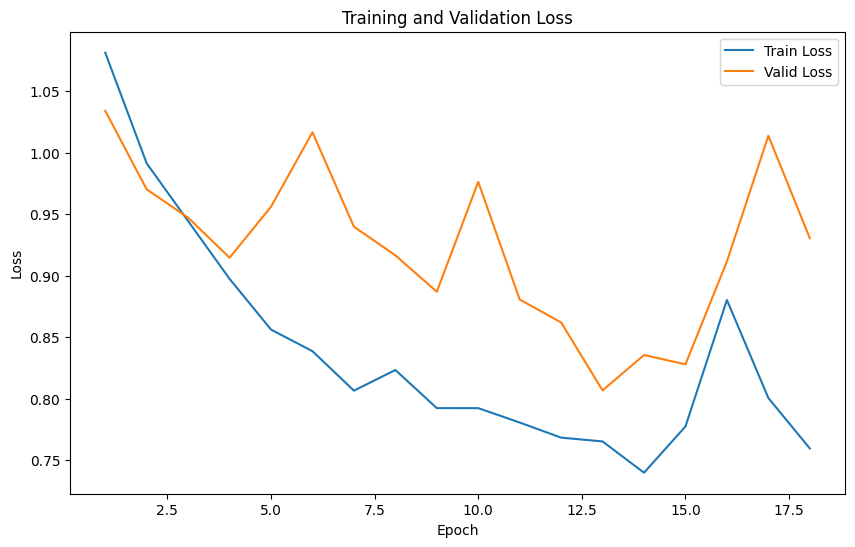

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Train Loss')
plt.plot(range(1, len(valid_losses) + 1), valid_losses, label='Valid Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

Testing

In [ ]:
total_correct = 0
correct=0
total_samples = 0
sample=0

with torch.no_grad():
     for audios, labels in test_dataloader:

        audios = audios.to(device)
        labels = labels.to(device)

        outputs = model(audios)
        threshold = 0.2
        preds = (outputs > threshold).float()
        preds=preds.cpu()

        for i in range(len(labels)):
          labels=labels.cpu()
          if np.argmax(preds[i] == np.argmax(labels[i])):
             correct = correct + 1
          sample=sample+1

          total_samples=sample

# Calculate test accuracy
test_accuracy = correct / sample

print(f'Total Correct Predictions: {correct}')
print(f'Total Samples: {total_samples}')
print(f'Test Accuracy: {test_accuracy*100:.2f}%')

Total Correct Predictions: 13
Total Samples: 24
Test Accuracy: 54.17%
